In [7]:
import matplotlib.pyplot as plt
import numpy as np
import time

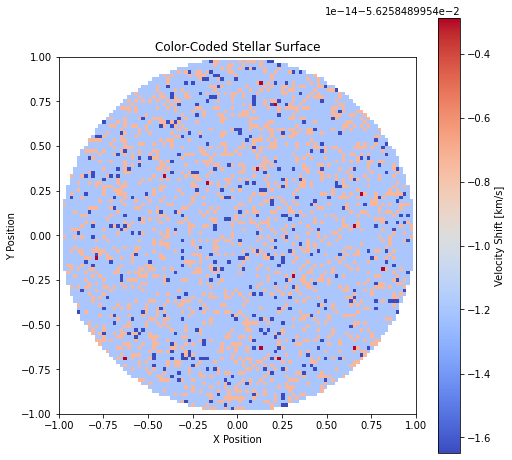

In [34]:
# Constants
nVelocity = 401
minx = -100
maxx = 100
mc_value = 60000
x_p = 5
y_p = 5
profiles = 10
vel_eq = 25
observer_angle = 45

# Definition of the gaussian profile
def gaussian_fct(x, amp, cen, sigma):
    return amp * (np.exp((-1.0 / 2.0) * (((x - cen) / sigma) ** 2)))

# Velocity shift
def shift_profile_velocity(x, y, velocity):
    shift = velocity
    xshifted = x + shift
    yshifted = np.interp(x, xshifted, y)
    return yshifted

# Limb darkening
def limb_dark(eps, radius):
    ld = 1.0 - eps + eps * np.cos(np.arcsin(radius))
    return ld

# Projected rotational velocity
def proj_vel(vel_eq, x_comp, observer_angle):
    pv = vel_eq * x_comp * np.cos(np.radians(observer_angle))
    return pv

# MC integration
def mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, n_mc):
    r_s, r_p = 1.0, 0.156
    x_p, y_p = x_p, y_p
    vel_eq, eps = vel_eq, 0.7
    n_mc = n_mc
    r_act = r_s

    amplitude = 0.9
    center = 0.0
    sigma = 5.0

    n_out = 0
    checkflux1 = 0.0
    checkflux2 = 0.0

    velocityArray = np.linspace(minx, maxx, nVelocity)
    flux_profile = np.zeros([nVelocity])
    flux = 0.0
    int_profile = gaussian_fct(velocityArray, amplitude, center, sigma)

    x_array_mc = np.zeros([n_mc])
    y_array_mc = np.zeros([n_mc])
    r_array_mc = np.zeros([n_mc])

    # Vectorized version
    theta_mc = np.random.uniform(0, 2. * np.pi, n_mc)
    r_mc = np.random.uniform(0, r_act, n_mc)

    for i in range(n_mc):
        x_mc = np.sqrt(r_mc[i]) * np.cos(theta_mc[i])
        y_mc = np.sqrt(r_mc[i]) * np.sin(theta_mc[i])
        check_planet = (np.abs(x_mc - x_p)) ** 2 + (np.abs(y_mc - y_p) ** 2) > r_p ** 2

        if check_planet:
            x_array_mc[i] = x_mc
            y_array_mc[i] = y_mc
            r_array_mc[i] = np.sqrt(x_mc ** 2 + y_mc ** 2)
            pv = proj_vel(vel_eq, x_mc, observer_angle)
            ld = limb_dark(eps, r_array_mc[i])
            local_profile = shift_profile_velocity(velocityArray, int_profile, pv)
            local_profile = local_profile * ld
            flux_profile = flux_profile + local_profile
            flux = flux + ld
            n_out = n_out + 1

    flux = flux * (r_s ** 2) / (r_act ** 2)
    flux_profile = flux_profile / flux

    return flux_profile, flux

# Create a grid for the stellar surface
grid_size = 100
x_grid = np.linspace(-1, 1, grid_size)
y_grid = np.linspace(-1, 1, grid_size)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
z_grid = np.zeros_like(x_grid)

# Iterate over the grid and calculate the profiles
for i in range(grid_size):
    for j in range(grid_size):
        x_p = x_grid[i, j]
        y_p = y_grid[i, j]
        # Skip points outside the stellar radius
        if x_p**2 + y_p**2 <= 1.0:
            try:
                flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, mc_value)
                # Calculate the mean velocity shift for coloring
                mean_velocity_shift = np.mean(velocityArray - flux_profile)
                z_grid[i, j] = mean_velocity_shift
            except Exception as e:
                print(f"Error at grid point ({i}, {j}): {str(e)}")
        else:
            z_grid[i, j] = np.nan  # Mark outside points with NaN

# Plot the stellar surface with color coding
plt.figure(figsize=(8, 8))
plt.imshow(z_grid, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm')
plt.colorbar(label='Velocity Shift [km/s]')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Color-Coded Stellar Surface')
plt.show()